## 1. JAX As Accelerated NumPy

- [JAX Tutorial: JAX As Accelerated NumPy](https://jax.readthedocs.io/en/latest/jax-101/01-jax-basics.html)

### JAX NumPy 시작하기

- 기본적으로 JAX는 배열 조작 프로그램의 변환을 가능하게 해주는 NumPy-like한 API

- 현재로써 JAX는 accelerator로 구동 가능한 NumPy라고 생각하면 됨

In [1]:
import jax
import jax.numpy as jnp

In [2]:
x = jnp.arange(10)
print(x)

2024-02-27 00:12:05.530858: W external/xla/xla/service/gpu/nvptx_compiler.cc:744] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


[0 1 2 3 4 5 6 7 8 9]


- JAX의 가장 큰 장점은 새로이 API를 배울 필요가 없다는 것

- 일반적으로 NumPy 프로그램은 np를 jnp로 대체하는 경우 JAX에서도 잘 실행됨

- 몇 가지 중요한 차이점은 마지막 부분에 설명

In [3]:
x

Array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

- JAX의 유용한 기능 중 하나는 동일한 코드를 CPU, GPU, TPU 등 다양한 백엔드에서 실행할 수 있다는 것

- Technical detail

    - JAX 함수가 호출될 때 해당 연산이 가능한 경우, 비동기적으로 계산될 수 있도록 accelerator로 전송됨

    - 따라서, 반환된 배열은 함수가 반환되는 즉시 '채워지는(filled in)' 것은 아님

    - 결과가 즉시 필요하지 않은 경우, 연산이 파이썬의 execution을 즉시 차단하지 않음
    
    - `block_until_ready`를 실행하거나 일반적 Python type으로 배열을 변환하지 않는 한 실제 연산 시간이 아닌 dispatch 시간만 계산됨

In [4]:
long_vector = jnp.arange(int(1e7))
%timeit jnp.dot(long_vector, long_vector).block_until_ready()

1.22 ms ± 29 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### 첫 번째 JAX 기반 변환: `grad`

- JAX의 기본 기능은 함수를 변환하는 것

- 가장 일반적으로 사용되는 변환 중 하나는 ㅍ파이썬으로 작성된 수치 함수를 가져와 원래 함수의 기울기를 계산하는 `jax.grad`

In [5]:
def sum_of_squares(x):
    return jnp.sum(x**2)

- `jax.grad`를 `sum_of_squares`에 적용하면 첫 번째 매개변수 `x`에 대한 `sum_of_squares`의 기울기를 반환

- 그런 다음 배열에서 해당 함수를 사용해 배열의 각 요소에 대한 도함수를 반환할 수 있음

In [6]:
sum_of_squares_dx = jax.grad(sum_of_squares)

x = jnp.asarray([1.0, 2.0, 3.0, 4.0])

print(sum_of_squares(x))
print(sum_of_squares_dx(x))

30.0
[2. 4. 6. 8.]


- $\nabla$와 같이 `jax.grad`는 스칼라 출력이 있는 함수에서만 작동하며, 그렇지 않은 경우 에러 발생
- 따라서, JAX API는 loss tensor 자체를 사용해 기울기를 계산하는 (e.g., `loss.backward()`) 다른 자동미분 라이브러리와는 상당히 다름
- JAX API는 함수를 직접 사용해 기본적인 '수학'에 조금 더 가깝게 작동함

    - 여기에 익숙해지면, loss function이 실제로 매개변수와 데이터의 '함수'이며, 수학에서와 마찬가지로 기울기를 찾을 수 있다는 점이 자연스럽게 느껴질 것
    
    - 이러한 방식을 사용하면 어떤 변수를 기준으로 미분할지 등을 간단히 조작할 수 있음

In [7]:
def sum_squared_error(x, y):
    return jnp.sum((x - y)**2)

In [8]:
sum_squared_error_dx = jax.grad(sum_squared_error)

y = jnp.asarray([1.1, 2.1, 3.1, 4.1])

print(sum_squared_error_dx(x, y))

[-0.20000005 -0.19999981 -0.19999981 -0.19999981]


- 다른 여러 argument에 대한 기울기를 찾고 싶다면 `argnums`를 설정하면 됨

In [9]:
display(jax.grad(sum_squared_error, argnums=(0, 1))(x, y)) # x와 y에 대한 편미분 값을 모두 반환

(Array([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32),
 Array([0.20000005, 0.19999981, 0.19999981, 0.19999981], dtype=float32))

- 그렇다면, ML 코드를 짤 때 거대한 매개변수 배열에 대해 거대한 argument list로 함수를 작성해야 할까?
- 아니다. JAX에는 '`pytree`'라는 메커니즘이 탑재되어 있어 데이터 구조로 배열을 함께 묶을 수 있음
- 따라서 `jax.grad`는 다음과 같이 사용할 수 있음

    ```python
    def loss_fn(params, data):
        ...

    grads = jax.grad(loss_fn)(params, data_batch)
    ```

### Value and Grad

- Training loss를 기록하는 등 함수의 value와 gradient를 모두 찾아야 하는 경우들이 종종 있음
- JAX에는 이를 효율적으로 수행하기 위한 변환들이 있음
- 어떤 함수 `f`라도 다음과 같이 확인할 수 있음

    ```python
    jax.value_and_grad(f)(*xs) == (f(*(xs), jax.grad(f)(*xs)))
    ```

In [12]:
value, grad = jax.value_and_grad(sum_squared_error)(x, y)

print(value)
print(grad)

0.039999947
[-0.20000005 -0.19999981 -0.19999981 -0.19999981]


### Auxiliary Data

- 값을 기록하는 것 외에도, loss function을 계산할 때 얻은 중간 결과를 보고할 때도 있음

- 그러나 일반적인 `jax.grad`를 통해 이를 시도하면 에러가 발생

In [13]:
def squared_error_with_aux(x, y):
    return sum_squared_error(x, y), x - y

In [14]:
display(jax.grad(squared_error_with_aux)(x, y))

TypeError: Gradient only defined for scalar-output functions. Output was (Array(0.03999995, dtype=float32), Array([-0.10000002, -0.0999999 , -0.0999999 , -0.0999999 ], dtype=float32)).

- `jax.grad`는 스칼라 함수에만 정의되어 있고, 새로 생긴 함수는 tuple을 반환하기 때문

- 그런데 중간 결과를 반환하려면 tuple이여야만 하는걸? --> `has_aux`가 있음

- `has_aux`는 함수가 쌍(`(out, aux)`)을 반환한다는 것을 의미하며, `jax.grad`가 `aux`를 무시하고 마치 `out`만 반환되는 것처럼 수행

In [15]:
display(jax.grad(squared_error_with_aux, has_aux=True)(x, y))

(Array([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32),
 Array([-0.10000002, -0.0999999 , -0.0999999 , -0.0999999 ], dtype=float32))

### NumPy와의 차이점

- 가장 중요한 차이점이자, 다른 모든 차이점들의 근원은 JAX가 함수형 프로그래밍(functional programming)에서와 같이 functional-style로 설계되었다는 점

- JAX가 수행하는 transformation의 종류가 함수형 프로그램에서 훨씬 더 잘 실현 가능하기 때문

- JAX로 작업할 때 알아둬야 할 가장 중요한 함수형 프로그래밍의 특징은, 'side-effect'가 없는 코드를 작성해야한다는 것

    - Side-effect: 출력에 나타나지 않는 함수의 모든 effect

    - e.g., 배열을 제자리에서 (in-place) 수정하는것

In [17]:
import numpy as np

x = np.array([1, 2, 3])
display(x)

def in_place_modify(x):
    x[0] = 123

in_place_modify(x)
display(x)

array([1, 2, 3])

array([123,   2,   3])

- 위처럼 side-effect 함수는 argument를 수정하지만 전혀 관련이 없는 값을 반환

- JAX는 배열을 in-place로 수정하는 것을 허용하지 않음 (= immutable)

In [18]:
in_place_modify(jnp.array(x))

TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

- `jax.numpy.ndarray.at`의 index update 연산자를 통해 side-effect 없는 JAX의 방식이 있음

    - 위에서 설명했듯이, old-array는 건드리지 않음 --> no side-effect

- 인덱스 별 in-place 수정과 유사하지만, 이는 해당 수정 작업이 수행된 새로운 배열을 생성한다는 것에 주의

In [20]:
def jax_in_place_modify(x):
    return x.at[0].set(123)

y = jnp.array([1, 2, 3])
display(y)

y = jax_in_place_modify(y)
display(y)

Array([1, 2, 3], dtype=int32)

Array([123,   2,   3], dtype=int32)

- Side-effect가 없는 코드를 functionally-pure 또는 pure라고 부르기도 함

- Pure 버전 코드는 엄밀히 말하자면 새로운 배열을 생성하기 때문에 효율성이 떨어짐

- 그러나, JAX의 연산은 보통 `jax.jit`이라는 또 다른 변환을 사용하여 실행되기 전에 컴파일 됨

    - 인덱스 업데이트 연산자를 사용해 'in-place'로 수정한 후, 이전 배열을 사용하지 않는다면 컴파일러가 알아서 in-place 수정으로 컴파일할 수 있음을 인식해 결국은 효율화에 성공함

- 물론, side-effectual한 Python 코드와 functionally-pure한 JAX의 코드를 혼합할 수도 있음

    - 그러나, 경험적으로 JAX로 변환하려는 함수는 side-effect를 피하는 것이 좋고, JAX primitive는 이를 지향함

### 첫 번째 JAX 기반 반복분

- 간단한 선형 회귀 코드로 시작

- 수식은 $y = w_{\text{true}}x + b_{\text{true}} + \epsilon$

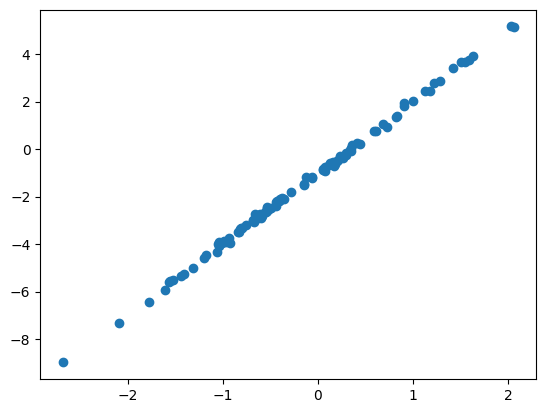

In [24]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.random.normal(size=(100,))
noise = np.random.normal(scale=0.1, size=(100,))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys)
plt.show()

- 따라서, 모델은 $\hat{y}(x;\theta) = wx + b$가 되며, $w$와 $b$를 모두 저장하기 위해 단일 배열인 `theta = [w, b]`를 사용

In [25]:
def model(theta, x):
    """Computes wx + b on a batch of input x."""
    w, b = theta
    return w * x + b

- 그렇다면, loss function은 $J(x,y;\theta) = (\hat{y} - y)^2$가 됨

In [26]:
def loss_fn(theta, x, y):
    prediction = model(theta, x)
    return jnp.mean((prediction - y)**2)

- Loss function을 최적화하기 위해 gradient descent를 사용

    $$
    \theta_\text{new} = \theta - 0.1(\nabla_\theta J)(x,y;\theta)
    $$

In [27]:
def update(theta, x, y, lr=0.1):
    return theta - lr * jax.grad(loss_fn)(theta, x, y)

- 위에서 설명했던 JAX의 기능적 특성 (in-place 수정이 불가하다는 것) 상, 매 단계 호출되는 `update()` 함수를 정의해 현재 매개변수를 입력으로 받고, 새로운 매개변수를 반환해야 함

- 그 다음, 이 함수는 효율성을 극대화하기 위해 JIT 컴파일을 거칠 수 있음

    - `update()` 함수 위에 데코레이터를 이용해 `@jax.jit`을 불러올 수도 있음

w: 2.99, b: -0.99


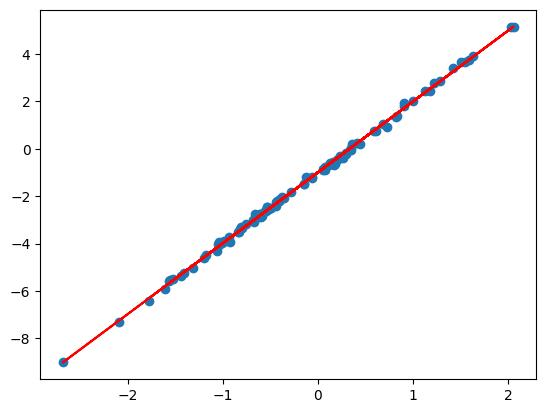

In [29]:
theta = jnp.array([1., 1.])

for _ in range(1000):
    theta = update(theta, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, model(theta, xs), color='red')

w, b = theta
print(f"w: {w:<.2f}, b: {b:<.2f}")

- 위의 기본 recipe는 JAX에서 구현되는 거의 모든 training loop의 기초가 됨

- 이 예제와 실제 trainint loop의 가장 큰 차이점은 모델의 단순성

    - 단일 배열로 모든 파라미터를 저장할 수 있음

- 이후 pytree 가이드에서는 더 많은 파라미터를 관리하는 방법을 다룰 예정이며, 해당 부분을 자유롭게 건너 뛰고 JAX에서 간단한 MLP를 정의하고 훈련하는 방법을 확인해도 됨